# Uncertainty Quantification in Deep Learning (Classification)

Rubén Martínez Cantín, Javier Civera

rmcantin@unizar.es

University of Zaragoza

In this part, we will analyze the performance of scalable Bayesian networks for classification problems. We will use the MNIST dataset.

Do the following tasks:
* Run the code and make sure you understand all of the cells.
* Train a neural network and an ensemble, and compare their accuracies.
* Approximate the epistemic variance using MC Dropout and compare its accuracy with respect to the previous ones. Remember that for MC Dropout you need to add the layer:
```
x = F.Dropout(x, p=dropout_p, training=True)
```
instead of
```
x = self.drop(x)
```
The difference is that `self.drop` use a `nn.Module` which already defines if the network is training or testing (and deactivates dropout for testing). Using the functional version `F.Dropout` we can force the layer to be always active by tricking the layer to think to it is always training.
* Analyze the dependencies of the accuracy with respect to the number of samples.
* Roughly, we can relate the spread of the categorical probabilities with the aleatoric uncertainty and its variability between forward passes with the epistemic uncertainty. Find in the MNIST dataset test samples that have high uncertainty and comment on them. Alternatively, we can approximate the full covariance matrix of the posterior predictive distribution as:

$$
\sigma^2 = \underbrace{\frac{1}{M} \sum_{i=1}^M \left(\mathbf{p}_i - \bar{\mathbf{p}}\right)^{\otimes^2}}_{\text{epistemic}} + \underbrace{\frac{1}{M} \sum_{i=1}^M \text{diag}(\mathbf{p}_i)-\mathbf{p}_i^{\otimes^2}}_{\text{aleatoric}}
$$
where $\mathbf{p}_i$ is the predicted probabilities for each class for the i-th sample, with $\bar{\mathbf{p}} = \frac{1}{M} \sum_{i=1}^M \mathbf{p}_i$ and remember that $x^{\otimes^2} = x x^T$. The trace of the covariance matrix gives you an approximation of the total variance (disregarding correlations).
* Load the Fashion MNIST dataset and predict using the Bayesian models trained in MNIST. Are the predicted uncertainties reasonable?

https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html

* Corrupt the test images with random noise or other perturbations (rotate image, flip colors, etc.) and report the behaviour of the uncertainties.

If you want, you can make several copies of this notebook and train each method in a different colab (Monte Carlo, Ensembles and Laplace).

In [ ]:
#@title Install Dependencies
#@markdown Laplace-torch is required for laplace. You can remove this for MC-dropout and ensembles

!pip install netcal
!pip install laplace-torch

In [ ]:
#@title Import Dependencies
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torch.distributions as dists
import torchvision.transforms as transforms

from netcal.metrics import ECE

#@markdown Again, the last import is only required for Laplace. Remove it if you are only doing MC or ensembles.
from laplace import Laplace

In [ ]:
#@title Downloading MNIST data
#@markdown For the Fashion MNIST data, just replace **MNIST** with **FashionMNIST**

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

In [ ]:
#@title Show some random training samples
#@markdown This is just an example. You can also use this to evaluate your data manipulation.
num_random_samples = 4
random_samples = np.random.randint(0, len(train_data), num_random_samples)
fig, axes = plt.subplots(1,num_random_samples)
for random_sample_i, ax1 in zip(random_samples,axes):
    imi = train_data[random_sample_i][0].reshape(28,28)
    figtitle = 'Label: %s' % (train_data[random_sample_i][1])
    ax1.imshow(imi, cmap=plt.get_cmap('gray'))
    ax1.set_title(figtitle)
    print("Loading training image #%d" % random_sample_i)
plt.show()


In [ ]:
#@title Define Hyperparameters
#@markdown Hyperparameters for the different algoritms, model, etc. Feel free to add more if needed.
#@markdown
#@markdown **TODO:** The hyperparameters are NOT optimal. Change them as need it.
#@markdown Also, consider reducing the number of epochs and ensembles for development.

#input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
#hidden_size = 500 # number of nodes at hidden layer

num_ensembles = 32 #@param {type: "integer"}
num_classes = 10 #@param {type: "integer"} # number of output classes discrete range (0,9)
num_epochs = 20  #@param {type: "integer"} # number of times which the entire dataset is passed throughout the model
batch_size = 100 #@param {type: "integer"} # the size of input data took for one iteration
lr = 1e-3 #@param {type: "number"} # size of step
weight_decay = 0.005 #@param {type: "number"}
dropout_p = 0.5 #@param {type: "number"}

use_gpu = True #@param {type: "boolean"}
gpu_id = 0

if torch.cuda.is_available() and use_gpu:
    device = torch.device("cuda:" + str(gpu_id))
    print("Using GPU id {}".format(gpu_id))
else:
    device = torch.device("cpu")
    print("GPU not detected. Defaulting to CPU.")

Using GPU id 0


In [ ]:
#@title Loading the data
train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                        batch_size = batch_size,
                                        shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                       batch_size = batch_size,
                                       shuffle = False)

In [ ]:
#@title Define model class
#@markdown This is very basic CNN for classification that you can use.
#@markdown Note that the dropout layer as it is configured is inactive at test time.
#@markdown
#@markdown **TODO:** This model is not optimal for any of the datasets.
#@markdown You should try different models, like a pure MLP.
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1,
                           out_channels=32,
                           kernel_size=3,
                           stride=3)

    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2)
    self.drop = nn.Dropout(p=dropout_p)
    self.flat = nn.Flatten()

    self.fc1 = nn.Linear(512, 256)
    self.fc2 = nn.Linear(256, num_classes)


  def forward(self,x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.drop(x)
    x = self.flat(x)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
#@title Train and evaluate model
#@markdown Functions for training and evaluating the model. Note that the training
#@markdown function is set to evaluate the model after each epoch. You can change
#@markdown that behaviour.

def eval_step(model, test_gen, loss_function):
    model.eval()
    train_acc = 0
    val_loss = 0
    with torch.no_grad():
        for i ,(images,labels) in enumerate(test_gen):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss_val = loss_function(outputs, labels)

            # Calculate and accumulate accuracy metric across all batches
            pred_class = torch.argmax(torch.softmax(outputs, dim=1), dim=1).detach().cpu().numpy()
            train_acc += accuracy_score(labels.cpu(), pred_class)

    val_loss = loss_val.item()

    return val_loss, train_acc/len(test_gen)

def train_model(model, train_gen, test_gen, loss_function, optimizer):
    for epoch in range(num_epochs):
        model.train()
        for i ,(images,labels) in enumerate(train_gen):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

        val_loss, train_acc = eval_step(model, test_gen, loss_function)

        print('Epoch [%d/%d], Loss: %.4f, Val loss: %.4f, Val acc: %.4f'
                      %(epoch+1, num_epochs, loss.item(), val_loss, train_acc))

In [ ]:
#@title Training the model

#@markdown This code already implements deep ensembles.
#@markdown
#@markdown Because all models inherit from `nn.Module`, pytorch already perform
#@markdown random initialization for us each time we create a new model.
#@markdown You can train ensembles with different base models.
#@markdown

models = []

for im in range(num_ensembles):
    print('Training model %d out of %d...........................................................' % (im+1, num_ensembles))
    # Define loss-function & optimizer
    model = Net().to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_model(model, train_gen, test_gen, loss_function, optimizer)

    models.append(model)

In [ ]:
#@title Example on how to evaluate deep ensembles

#@markdown Remember that in deep ensembles, the prediction is the average response
#@markdown Itcan also be used for other sample forms like MC-dropout.

def eval_ensembles(models, test_gen):
    train_acc = 0
    val_loss = 0
    with torch.no_grad():
      for i ,(images,labels) in enumerate(test_gen):
        images = images.to(device)
        labels = labels.cpu()

        outputs = []

        for model in models:
            model.eval()
            outputs.append(torch.softmax(model(images),dim=1))

        # Compute the mean value for all models
        result = torch.mean(torch.stack(outputs), dim=0)

        # Calculate and accumulate accuracy metric across all batches
        pred_class = torch.argmax(result, dim=1).detach().cpu().numpy()
        train_acc += accuracy_score(labels, pred_class)

    return train_acc/len(test_gen)

Loading test image #5548
Loading test image #6511
Loading test image #3330
Loading test image #1547


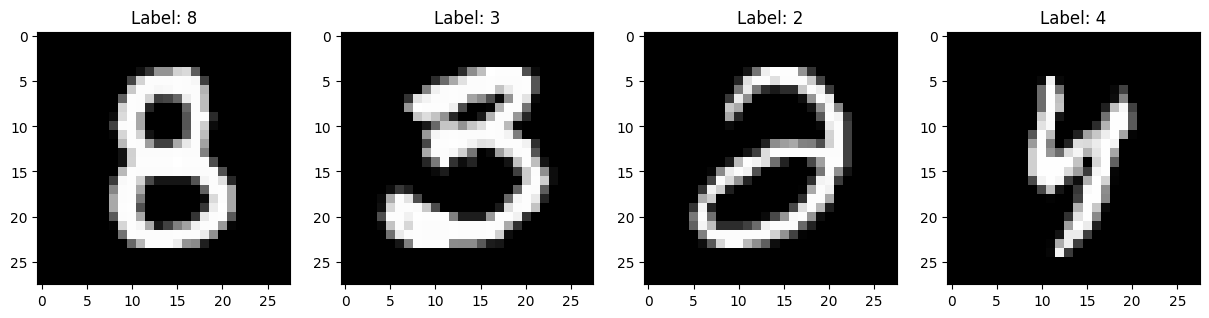

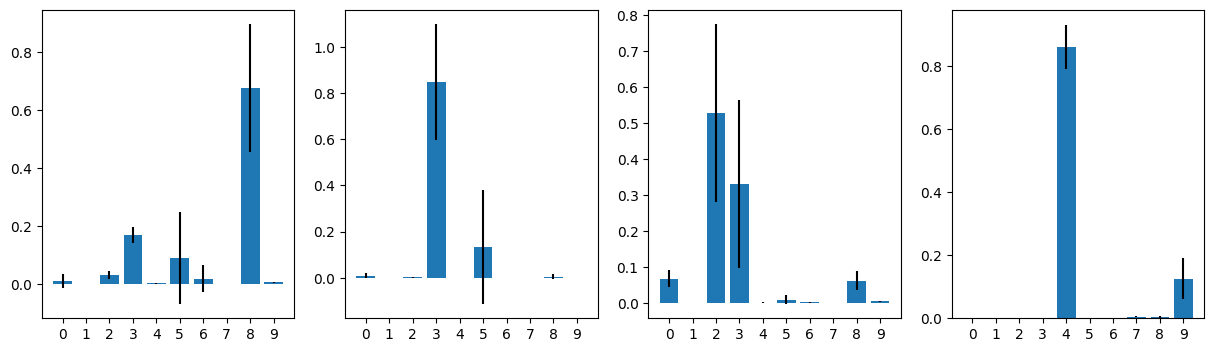

In [ ]:
#@title Display ensemble results for sample test digits
#@markdown This is just an example of the kind of evaluations that you can perform.
#@markdown We show a histogram with the average probabilities and error bars for
#@markdown the uncertainty of the ensembles.

num_random_samples = 4
random_samples = np.random.randint(0, len(test_data), num_random_samples)
fig, axes = plt.subplots(1,num_random_samples, figsize=(15, 4))
fig2, axes2 = plt.subplots(1,num_random_samples, figsize=(15, 4))
for i_sample, ax1, ax2 in zip(random_samples,axes, axes2):

  # plot the image
  imi = test_data[i_sample][0].reshape(28,28)
  figtitle = 'Label: %s' % (test_data[i_sample][1])
  ax1.imshow(imi, cmap=plt.get_cmap('gray'))
  ax1.set_title(figtitle)

  print("Loading test image #%d" % i_sample)

  outputs = []

  for model in models:
    model.eval()
    outputs.append(torch.softmax(model(imi.view(1,1,28,28).to(device)),dim=1))

  # Compute the mean value for all models
  avg_probs = torch.mean(torch.stack(outputs), dim=0).squeeze().detach().cpu().numpy()
  std_probs = torch.std(torch.stack(outputs), dim=0).squeeze().detach().cpu().numpy()
  rangeprobls = np.array(range(10))

  ax2.bar(rangeprobls, avg_probs, yerr=3*std_probs, align='center')
  ax2.set_xticks(rangeprobls)

plt.show()

# Laplace model

In this part of the lab, we are going to use the Laplace approximation to approximate the posterior and predictive posterior distributions.

For the implemenation, we are going to use the Laplace-redux library
* Code: https://github.com/AlexImmer/Laplace
* Paper: https://arxiv.org/abs/2106.14806
* Docs: https://aleximmer.github.io/Laplace/

We assume that we have already a pretrained model. We will optimize the prior distribution, which we assume to be in ther form $\mathcal{N}(0, \lambda I)$, where $\lambda$ is called the **prior precision**.

You can play with the different configurations of weights and Hessian structure. See fig. 2 in the paper for a quick overview of the options. You can try using a less expensive approximation and optimize the hyperparamenters for more epochs.

**Note:** The hyperparameters for noise variance and prior precision are optimized in log-space $(\log \sigma_n^2, \log \lambda)$ because it is numerically more stable and produce better results.

We provide some code to evaluate the Laplace model as an example, but you should use your own metrics and analysis.

In [ ]:
#@title Fitting Laplace model
#@markdown We are going to use a pretrained model.
#@markdown See figure 2 of the paper on how to configure the Laplace approximation.
#@markdown Try changing the parameters of the `Laplace(...)` model (weights, Hessian...)


# Configure and fit the model
print('Fitting post-hoc Laplace model....................')
model = models[0]

# Laplace
la = Laplace(model, 'classification',
             subset_of_weights='last_layer',
             hessian_structure='full')
la.fit(train_gen)
la.optimize_prior_precision(method='marglik')

In [ ]:
#@title Evaluate Laplace model
#@markdown We compare the Laplace model to the homoscedastic and heteroscedastic
#@markdown deterministic models.
#@markdown We show some metrics as an example. You should do your own analysis.

targets = torch.cat([y for x, y in test_gen], dim=0).cpu()

@torch.no_grad()
def predict(dataloader, model, laplace=False):
    py = []

    for x, _ in dataloader:
        if laplace:
            py.append(model(x.to(device)))
        else:
            py.append(torch.softmax(model(x.to(device)), dim=-1))

    return torch.cat(py).cpu()


probs_map = predict(test_gen, model, laplace=False)
acc_map = (probs_map.argmax(-1) == targets).float().mean()
ece_map = ECE(bins=15).measure(probs_map.numpy(), targets.numpy())
nll_map = -dists.Categorical(probs_map).log_prob(targets).mean()

print(f'[MAP] Acc.: {acc_map:.1%}; ECE: {ece_map:.1%}; NLL: {nll_map:.3}')


probs_laplace = predict(test_gen, la, laplace=True)
acc_laplace = (probs_laplace.argmax(-1) == targets).float().mean()
ece_laplace = ECE(bins=15).measure(probs_laplace.numpy(), targets.numpy())
nll_laplace = -dists.Categorical(probs_laplace).log_prob(targets).mean()

print(f'[Laplace] Acc.: {acc_laplace:.1%}; ECE: {ece_laplace:.1%}; NLL: {nll_laplace:.3}')

# AUSE based on the Brier score.

In this part of the lab, we can compute the AUSE method as in the regression lab, but we need a continuous error metric. Thus, we use the Brier score.

**TODO:** Compute the uncertainty for each method using the equation described before:
$$
\sigma^2 = \underbrace{\frac{1}{M} \sum_{i=1}^M \left(\mathbf{p}_i - \bar{\mathbf{p}}\right)^{\otimes^2}}_{\text{epistemic}} + \underbrace{\frac{1}{M} \sum_{i=1}^M \text{diag}(\mathbf{p}_i)-\mathbf{p}_i^{\otimes^2}}_{\text{aleatoric}}
$$
Because this equation returns a covariance matrix and the AUSE requires a scalar value, you can use the trace (sum of the elements of the diagonal) or the determinant of the covariance matrix. You have an example using the MAP predictions (Note: for the MAP and Laplace cases M=1 and therefore, the epistemic term is 0).

In [ ]:
#@title AUSE based on the Brier score (MAP example).

def ause(abs_error, y_var, plot_curves=True):
  '''Computes the AUSE error based on the variance and absolute error.
     It also plots the figure with the sparsification curves.
     Feel free to modify the plot to your preferences.
  '''
  if torch.is_tensor(abs_error):
    abs_error = abs_error.detach().cpu().numpy()
  if torch.is_tensor(y_var):
    y_var = y_var.detach().cpu().numpy()

  abs_error /= np.sum(abs_error)
  idx_errors = np.argsort(abs_error)[::-1]
  idx_variances = np.argsort(y_var)[::-1]
  scurve_errors = np.array([1])
  scurve_variances = np.array([1])
  abs_error_sorted = abs_error[idx_errors]
  variances_sorted = abs_error[idx_variances]

  for _ in range(len(abs_error)-1):
    abs_error_sorted = np.delete(abs_error_sorted,0)
    scurve_errors = np.append(scurve_errors,np.sum(abs_error_sorted))
    variances_sorted = np.delete(variances_sorted,0)
    scurve_variances = np.append(scurve_variances,np.sum(variances_sorted))

  percentages = (np.arange(len(scurve_errors))+1) / len(scurve_errors)

  if plot_curves:
    plt.plot(percentages, scurve_errors)
    plt.plot(percentages, scurve_variances)
    plt.title('Sparsification error curves')
    plt.ylabel('mae')
    plt.xlabel('ratio of samples removed')
    plt.legend(['oracle', 'model'], loc='lower left')
    plt.show()

  integral_errors = np.trapz(scurve_errors, percentages)
  integral_variances = np.trapz(scurve_variances, percentages)

  return np.abs(integral_errors - integral_variances)

# We use sklearn to compute the Brier score, but we need a one-hot-encoding of
# the labels. For example, the second label is represented as [0 1 0 .. 0]
from sklearn.preprocessing import label_binarize
from sklearn.metrics import brier_score_loss

targets_binarize = label_binarize(targets, classes=np.unique(targets))
brier_scores_map = [
    brier_score_loss(targets_binarize[i,:], probs_map[i,:])
    for i in range(targets_binarize.shape[0])
]

# In this case, this is based on the trace of the aleatoric term.
y_var_map = [
    torch.sum(probs_map[i,:]-probs_map[i,:]*probs_map[i,:])
    for i in range(probs_map.shape[0])
    ]

print("AUSE MAP:", ause(brier_scores_map, y_var_map))

# Other datasets (e.g.: CIFAR-10)

You can also try with other datasets such as CIFAR-10. Here you have some code snippets that you need to change above to use the CIFAR-10 dataset.

In [ ]:
#@title Downloading CIFAR-10 data
#@markdown Note that we need to normalize the data.

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = dsets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_data = dsets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
#@title Show some random training samples
#@markdown In this case we need to reshape and revert the normalization accordingly.

#@markdown This is just an example. You can also use this to evaluate your data manipulation.
num_random_samples = 4
random_samples = np.random.randint(0, len(train_data), num_random_samples)
fig, axes = plt.subplots(1,num_random_samples)
for random_sample_i, ax1 in zip(random_samples,axes):
    imi = train_data[random_sample_i][0].reshape(3,32,32).numpy().transpose(1,2,0) / 2 + 0.5
    figtitle = 'Label: %s' % (classes[train_data[random_sample_i][1]])
    ax1.imshow(imi)#, cmap=plt.get_cmap('gray'))
    ax1.set_title(figtitle)
    print("Loading training image #%d" % random_sample_i)
plt.show()

In [ ]:
#@title Define model class
#@markdown This is very basic CNN for classification that you can use.
#@markdown Note that the dropout layer as it is configured is inactive at test time.
#@markdown
#@markdown **TODO:** You can found this model in the Pytorch tutorial,
#@markdown but probably it can be improved.
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.drop = nn.Dropout(p=dropout_p)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
#@title Display ensemble results for sample test digits
#@markdown In this case we need to reshape and revert the normalization accordingly.

#@markdown This is just an example of the kind of evaluations that you can perform.
#@markdown We show a histogram with the average probabilities and error bars for
#@markdown the uncertainty of the ensembles.

num_random_samples = 4
random_samples = np.random.randint(0, len(test_data), num_random_samples)
fig, axes = plt.subplots(1,num_random_samples, figsize=(15, 4))
fig2, axes2 = plt.subplots(1,num_random_samples, figsize=(15, 4))
for i_sample, ax1, ax2 in zip(random_samples,axes, axes2):

  # plot the image
  imi = test_data[i_sample][0].reshape(3,32,32).numpy().transpose(1,2,0) / 2 + 0.5
  figtitle = 'Label: %s' % (classes[test_data[i_sample][1]])
  ax1.imshow(imi)
  ax1.set_title(figtitle)

  print("Loading test image #%d" % i_sample)

  outputs = []

  for model in models:
    model.eval()
    outputs.append(torch.softmax(model(test_data[i_sample][0].view(1,3,32,32).to(device)),dim=1))

  # Compute the mean value for all models
  avg_probs = torch.mean(torch.stack(outputs), dim=0).squeeze().detach().cpu().numpy()
  std_probs = torch.std(torch.stack(outputs), dim=0).squeeze().detach().cpu().numpy()
  rangeprobls = np.array(range(10))

  ax2.bar(rangeprobls, avg_probs, yerr=3*std_probs, align='center')
  ax2.set_xticks(rangeprobls, classes, rotation=45)

plt.show()